# Locally Linear Embedding

![Mahdieh](passport_photo.jpg)

Creator : *Mahdieh Alizadeh* 

Email address: Mahdieh20201@gmail.com

Machine Learning 1403-fall


In this file the  Locally linear embedding (LLE) method for dimensionality reduction is introduced. The method is based on simple geometric intuitions:
If a data set is sampled from a smooth manifold, then neighbors of each point remain nearby and are similarly co-located in the low-dimensional space. In LLE, eachpoint in the data set is linearly embedded into a locally linear patch of the manifold. Then low-dimensional data is constructed such that the locally linear relations of the original data are preserved.
Locally Linear Embedding (LLE) was first proposed by Roweis and Saul (2000) and developed further in subsequent works and as i said before The main idea of LLE is to preserve the local geometry of data points in a lower-dimensional embedding space. LLE can be broken down into three main steps: 

1. **Finding k-Nearest Neighbors (kNN)** 
2. **Linear Reconstruction by the Neighbors** 
3. **Linear Embedding using the Calculated Weights**



## k-Nearest Neighbors

In the first step of LLE, a kNN graph is formed using pairwise Euclidean distances between data points. For each data point $ x_i $, the algorithm finds its k-nearest neighbors $ x_{ij} $, where $ j $ denotes the j-th neighbor of $ x_i $. Mathematically, the matrix of neighbors can be expressed as:

$$
X_i := [x_{i1}, x_{i2}, ..., x_{ik}] \in \mathbb{R}^{d \times k}
$$

where $ d $ is the dimensionality of the original data, and $ k $ is the number of neighbors.

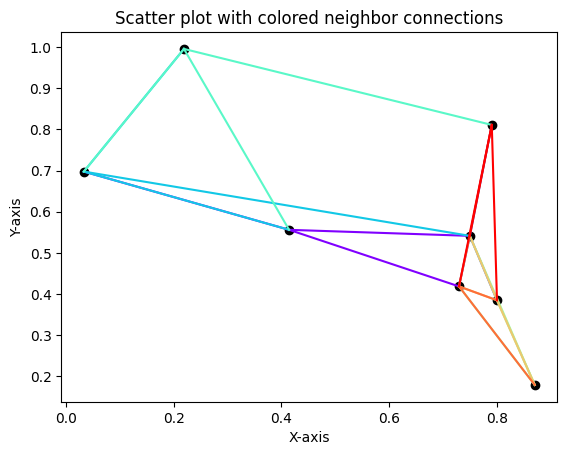

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.cm as cm

data = np.random.rand(8, 2)

def kneighbors(n_neighbors, data):
    knn_model = NearestNeighbors(n_neighbors=n_neighbors+1, metric='l2')
    knn_model.fit(data)
    kindices = knn_model.kneighbors(data)[1][:, 1:]
    return kindices

n_neighbors = 3
neighbors_indices = kneighbors(n_neighbors, data)

colors = cm.rainbow(np.linspace(0, 1, data.shape[0]))

plt.scatter(data[:, 0], data[:, 1], color='black')

for i in range(data.shape[0]):
    for j in neighbors_indices[i]:
        plt.plot([data[i, 0], data[j, 0]], [data[i, 1], data[j, 1]], color=colors[i])

plt.title("Scatter plot with colored neighbor connections")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


### Linear Reconstruction by the Neighbors
In the second step, we find the weights for linear reconstruction of every point by its kNN. The optimization for this linear reconstruction in the high dimensional input space is formulated as:

$$
\min_{\tilde{W}} \epsilon(\tilde{W}) := \sum_{i=1}^{n} \left\lVert x_i - \sum_{j=1}^{k} \tilde{w}_{ij} x_{ij} \right\rVert_2^2,
$$

subject to 

$$
\sum_{j=1}^{k} \tilde{w}_{ij} = 1, \quad \forall i \in \{1, \dots, n\},
$$

where $ \tilde{W} \in \mathbb{R}^{n \times k} := [\tilde{w}_1, \dots, \tilde{w}_n]^\top $ includes the weights, $ \tilde{w}_i \in \mathbb{R}^k := [\tilde{w}_{i1}, \dots, \tilde{w}_{ik}]^\top $ includes the weights of linear reconstruction of the $i$-th data point using its $k$ neighbors, and $x_{ij} \in \mathbb{R}^d$ is the $j$-th neighbor of the $i$-th data point.

The constraint $ \sum_{j=1}^{k} \tilde{w}_{ij} = 1 $ means that the weights of linear reconstruction sum to one for every point. Note that the fact that some weights may be negative causes the problem of explosion of some weights because very large positive and negative weights can cancel each other to have a total sum of one. However, this problem does not occur because, as we will see, the solution to this optimization problem has a closed form; thus, weights do not explode. If the solution was found iteratively, the weights would grow and explode gradually (Ghojogh et al., 2019d).

We can restate the objective $ \epsilon(\tilde{W}) $ as:

$$
\epsilon(\tilde{W}) = \sum_{i=1}^{n} \left\lVert x_i - X_i \tilde{w}_i \right\rVert_2^2,
$$

where the constraint $ \sum_{j=1}^{k} \tilde{w}_{ij} = 1 $ implies that $ 1^\top \tilde{w}_i = 1 $; therefore, $ x_i = x_i 1^\top \tilde{w}_i $. We can simplify the term in $ \epsilon(\tilde{W}) $ as:

$$
\left\lVert x_i - X_i \tilde{w}_i \right\rVert_2^2 = \left\lVert x_i 1^\top - X_i \right\rVert_2^2 = \left\lVert (x_i 1^\top - X_i) \tilde{w}_i \right\rVert_2^2 = \tilde{w}_i^\top G_i \tilde{w}_i,
$$

where $ G_i \in \mathbb{R}^{k \times k} $ is a gram matrix defined as:

$$
G_i := (x_i 1^\top - X_i)^\top (x_i 1^\top - X_i).
$$

Finally, the optimization problem can be rewritten as:

$$
\min_{\{\tilde{w}_i\}_{i=1}^{n}} \sum_{i=1}^{n} \tilde{w}_i^\top G_i \tilde{w}_i,
$$

subject to $ 1^\top \tilde{w}_i = 1, \quad \forall i \in \{1, \dots, n\}. $

The Lagrangian for this problem is:

$$
L = \sum_{i=1}^{n} \tilde{w}_i^\top G_i \tilde{w}_i - \sum_{i=1}^{n} \lambda_i (1^\top \tilde{w}_i - 1),
$$

Setting the derivative of the Lagrangian to zero gives:

$$
\frac{\partial L}{\partial \tilde{w}_i} = 2 G_i \tilde{w}_i - \lambda_i 1 = 0,
$$

which leads to:

$$
\tilde{w}_i = \frac{\lambda_i}{2} G_i^{-1} 1 = \frac{G_i^{-1} 1}{1^\top G_i^{-1} 1}.
$$

If $ G_i $ is singular, we add a small positive number $ \epsilon $ to its diagonal for regularization, as typically done in LLE.


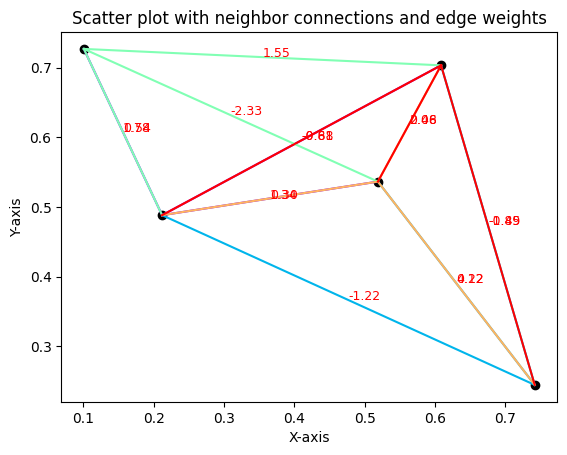

In [7]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.linalg import solve

def LinearReconustruction(data, n_neighbors, kindices):
        X = data
        n_samples = data.shape[0]
        ind = kindices

        def weights(n_samples, X, ind):
            B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
            v = np.ones(n_neighbors, dtype=X.dtype)

            
            for i, ind in enumerate(ind):
                A = X[ind]
                C = A - X[i]
                G = np.dot(C, C.T)
                trace = np.trace(G)
                if trace > 0:
                    R = 0.001 * trace
                else:
                    R = 0.001
                G.flat[:: n_neighbors + 1] += R
                w = solve(G, v, assume_a="pos")
                B[i, :] = w / np.sum(w)
            return B

        B = weights(n_samples, X, ind)
        indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
        weights =  csr_matrix((B.ravel(), ind.ravel(), indptr), shape=(n_samples, n_samples))
        return weights


# Sample data with shape (10, 2)
data = np.random.rand(5, 2)
n_neighbors = 3
kindices = kneighbors(n_neighbors, data)

# Get the weights using LinearReconstruction
weights = LinearReconustruction(data, n_neighbors, kindices)

# Create a colormap to assign different colors to different points
colors = cm.rainbow(np.linspace(0, 1, data.shape[0]))

# Plot the data points and their connections with the weights on the edges
plt.scatter(data[:, 0], data[:, 1], color='black')

# Draw lines between neighbors, with different colors for each point and label the weights
for i in range(data.shape[0]):
    for j in kindices[i]:
        # Plot line between point i and its neighbor j
        plt.plot([data[i, 0], data[j, 0]], [data[i, 1], data[j, 1]], color=colors[i])
        
        # Get the weight of the edge
        weight = weights[i, j]
        
        # Position the text at the midpoint of the line
        midpoint = ((data[i, 0] + data[j, 0]) / 2, (data[i, 1] + data[j, 1]) / 2)
        
        # Annotate the line with the weight
        plt.text(midpoint[0], midpoint[1], f'{weight:.2f}', fontsize=9, color='red')

plt.title("Scatter plot with neighbor connections and edge weights")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

## Linear Embedding

In the second step, we found the weights for linear reconstruction in the high-dimensional input space. In the third step, we embed data in the low-dimensional embedding space using the same weights as in the input space. This linear embedding can be formulated as the following optimization problem:

$$
\text{minimize}_Y \sum_{i=1}^{n} \left\| y_i - \sum_{j=1}^{n} w_{ij} y_j \right\|^2_2,
$$
subject to:
$$
\frac{1}{n} \sum_{i=1}^{n} y_i y_i^T = I, \quad \sum_{i=1}^{n} y_i = 0,
$$
where $ I $ is the identity matrix, the rows of $ Y \in \mathbb{R}^{n \times p} $ are the embedded data points (stacked row-wise), $ y_i \in \mathbb{R}^p $ is the $i$-th embedded data point, and $ w_{ij} $ is the weight obtained from the linear reconstruction if $x_j $ is a neighbor of $ x_i $ and zero otherwise.

$$
w_{ij} = \begin{cases} 
\tilde{w}_{ij} & \text{if } x_j \in \text{kNN}(x_i) \\
0 & \text{otherwise}.
\end{cases}
$$

The second constraint ensures the zero mean of embedded data points. The first and second constraints together satisfy having unit covariance for the embedded points.

Suppose $ w_i \in \mathbb{R}^n $ and let $ 1_i \in \mathbb{R}^n $ be the vector whose $i$-th element is one, and other elements are zero. The objective function can be restated as:

$$
\sum_{i=1}^{n} \left\| Y^T 1_i - Y^T w_i \right\|^2_2,
$$
which can be stated in matrix form as:

$$
\sum_{i=1}^{n} \left\| Y^T I - Y^T W^T \right\|^2_F = \left\| Y^T (I - W^T) \right\|^2_F,
$$

where $ W \in \mathbb{R}^{n \times n} $ contains the weights for each data point. This expression simplifies as:

$$
\left\| Y^T (I - W^T) \right\|^2_F = \text{tr}\left( (I - W^T) Y Y^T (I - W^T) \right) = \text{tr}(Y^T M Y),
$$

where $ M = (I - W^T)(I - W) $ is a matrix related to the Laplacian of $ W $.

Finally, the optimization problem becomes:

$$
\text{minimize}_Y \, \text{tr}(Y^T M Y),
$$
subject to:
$$
\frac{1}{n} Y^T Y = I, \quad Y^T 1 = 0.
$$

The columns of $ Y $ are the eigenvectors of $ M $ corresponding to the smallest non-zero eigenvalues, which form the embedded data points.


In [8]:
import numpy as np

def LinearEmbedding(n_components, weights):
        w_size = weights.shape[0]
        M = np.eye(w_size) - weights
        M = M.T @ M 
        eigenvalues, eigenvectors = np.linalg.eigh(M)
        indices = np.argsort(eigenvalues)[1:n_components+1]
        eigenvectors = np.real(eigenvectors[:, indices])  
        Y = eigenvectors
        return Y

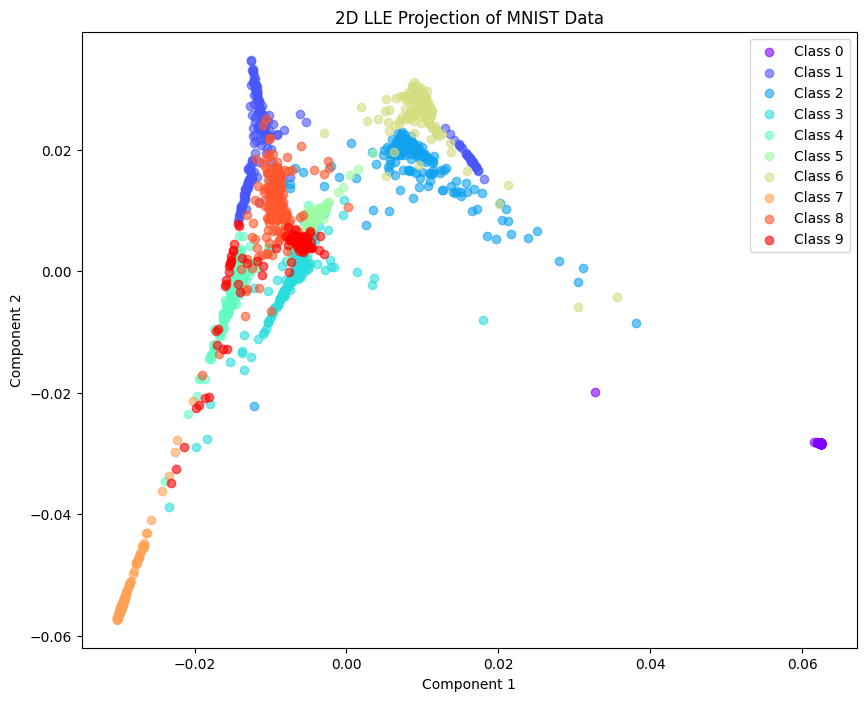

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from scipy.linalg import solve
from sklearn.datasets import load_digits

class LocallyLinearEmbedding(object):
    n_components: int
    n_neighbors: int
    data: np.ndarray
    weights: np.ndarray
    eigenvectors: np.ndarray  # Store the eigenvectors from fit_transform
    
    def __init__(self, n_components, n_neighbors) -> None:
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.reg = 1e-4

    def fit_transform(self, data):
        self.data = data
        self.kneighbors()
        self.LinearReconustruction()
        Y = self.LinearEmbedding()
        
        return np.asarray(Y)

    def kneighbors(self):
        self.knn_model = NearestNeighbors(n_neighbors=self.n_neighbors+1, metric='l2')
        self.knn_model.fit(self.data)
        self.kindices = self.knn_model.kneighbors(self.data, return_distance=False)[:, 1:]

        
    
    def LinearReconustruction(self):
        X = self.data
        n_samples = self.data.shape[0]
        ind = self.kindices

        def weights(n_samples, X, ind):
            B = np.empty((n_samples, self.n_neighbors), dtype=X.dtype)
            v = np.ones(self.n_neighbors, dtype=X.dtype)

            
            for i, ind in enumerate(ind):
                A = X[ind]
                C = A - X[i]
                G = np.dot(C, C.T)
                trace = np.trace(G)
                if trace > 0:
                    R = 0.001 * trace
                else:
                    R = 0.001
                G.flat[:: self.n_neighbors + 1] += R
                w = solve(G, v, assume_a="pos")
                B[i, :] = w / np.sum(w)
            return B

        B = weights(n_samples, X, ind)
        indptr = np.arange(0, n_samples * self.n_neighbors + 1, self.n_neighbors)
        self.weights =  csr_matrix((B.ravel(), ind.ravel(), indptr), shape=(n_samples, n_samples))

    def LinearEmbedding(self):
        n = self.weights.shape[0]
        M = np.eye(n) - self.weights
        M = M.T @ M

        eigenvalues, eigenvectors = np.linalg.eigh(M)
        indices = np.argsort(eigenvalues)[1:self.n_components+1] 
        self.eigenvectors = np.real(eigenvectors[:, indices])
        
        return self.eigenvectors

data = load_digits()
x, y = data.data, data.target
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_lle = lle.fit_transform(x)
plt.figure(figsize=(10, 8))

colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(y))))

for i, label in enumerate(np.unique(y)):
    plt.scatter(X_lle[y == label, 0], X_lle[y == label, 1], 
                color=colors[i], label=f'Class {label}', alpha=0.6)

plt.title("2D LLE Projection of MNIST Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

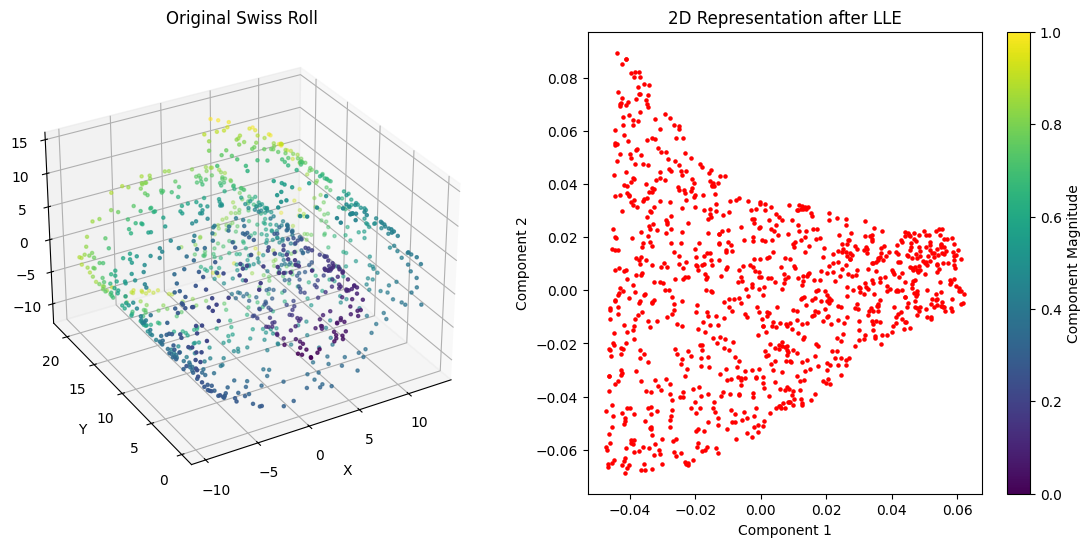

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

# Generate synthetic Swiss Roll data
X, _ = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)

# Apply LLE for dimensionality reduction
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
X_reduced = lle.fit_transform(X)

# Plot the original Swiss Roll as a surface
fig = plt.figure(figsize=(14, 6))

# 3D surface plot of the original Swiss Roll
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.sqrt(X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2), cmap='viridis', s=5)
ax1.set_title('Original Swiss Roll')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=30, azim=240)

# 2D plot of the reduced Swiss Roll
ax2 = fig.add_subplot(122)
sc = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c='red', s=5)
ax2.set_title('2D Representation after LLE')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

plt.colorbar(sc, ax=ax2, label='Component Magnitude')

plt.show()


### Table 1: Categorization of Extensions of the LLE

| Category                         | Approach                                                           |
|-----------------------------------|--------------------------------------------------------------------|
| Neighborhood selection            | Geodesic distance, weighted distance, kernel relative transformation, outlier removal |
| Computing weight matrix           | Linear local transformations, regularization parameter choice       |
| Computing the embedding           | Reducing the effect of outliers, explicitly unfolding the manifold  |
| Linear version of LLE             | Neighborhood Preserving Embedding, Distance-preserving LLE          |
| Out-of-sample extensions          | Transformation-based, incremental version                           |
| Supervised LLE                    | Using class labels, other supervised methods                        |



### Table 2: Extensions of LLE concerning Neighborhood Selection

| Method                           | Comments                                                              |
|-----------------------------------|-----------------------------------------------------------------------|
| Geodesic distance                 | Reduces short circuits, higher computational complexity                |
| Weighted distance                 | Handles unevenly sampled data, better internal feature extraction      |
| Local correlation                 | Better results in manifold learning                                   |
| Kernel relative transformation    | Reduces impact of noise                                                |
| New distance                      | Less sensitive to parameter \( k \)                                   |
| Outlier removal                   | Effective but computationally expensive                                |
| Using two searching rules         | Reduces noise impact, sensitive to additional parameters               |
| Automatic neighborhood size       | Tries to determine optimal \( k \), relies on cost function            |
| Neighbor smoothing                | Reduces noise, introduces additional parameters                        |
| Virtual data generation           | Deals with sparse data, higher computational complexity                |
| Short circuit edge pruning        | Reduces short circuits                                                 |


The extensions of LLE concerning neighborhood selection have been classified into three groups, i.e. using other distance metric, using other rules to select neighbors,and embedding extra processing on the selected neighborhood. The features of these
methods have been summarized in Table 2.


## References
1. Chen, Jing, and Zhengming Ma. "Locally Linear Embedding: A Review." *International Journal of Pattern Recognition and Artificial Intelligence*, vol. 25, no. 7, 2011, pp. 985-1008. DOI: 10.1142/S0218001411008993
2. Ghojogh, B., Ghodsi, A., Karray, F., & Crowley, M. (2020). Locally Linear Embedding and its Variants: Tutorial and Survey. arXiv preprint.
DOI: 10.48550/arXiv.2011.10925
3. Wang, J. (2012). Locally Linear Embedding. In Geometric Structure of High-Dimensional Data and Dimensionality Reduction (pp. 203-218). Springer-Verlag. 
DOI: 10.1007/978-3-642-27497-8_10​
